<a href="https://colab.research.google.com/github/LokeshVadlamudi/EmergingTechnologiesML/blob/master/Assignment_3/assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#importing the libraries

In [1]:

import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import tensorflow_hub as hub
import tensorflow_datasets as tfds

#function to count the number of parameters in the model

In [2]:
def count_params(checkpoint, excluding_vars=[], verbose=True):
  vdict = checkpoint.get_variable_to_shape_map()
  cnt = 0
  for name, shape in vdict.items():
    skip = False
    for evar in excluding_vars:
      if re.search(evar, name):
        skip = True
    if skip:
      continue
    if verbose:
      print(name, shape)
    cnt += np.prod(shape)
  cnt = cnt / 1e6
  print("Total number of parameters: {:.2f}M".format(cnt))
  return cnt

checkpoint_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/'
checkpoint = tf.train.load_checkpoint(checkpoint_path)
_ = count_params(checkpoint, excluding_vars=['global_step', "Momentum", 'ema', 'memory', 'head'], verbose=False)

Total number of parameters: 23.56M


#contacting google storage to download wordnet lemmas text file and store it

In [3]:
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt

imagenet_int_to_str = {}

with open('ilsvrc2012_wordnet_lemmas.txt', 'r') as f:
  for i in range(1000):
    row = f.readline()
    row = row.rstrip()
    imagenet_int_to_str.update({i: row})

tf_flowers_labels = ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

--2020-09-27 05:17:29--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 173.194.79.128, 108.177.126.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0s      

2020-09-27 05:17:29 (101 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt’ saved [21675/21675]



#function to provide randomness to our images

In [4]:
FLAGS_color_jitter_strength = 0.3
CROP_PROPORTION = 0.875  # Standard for ImageNet.


def random_apply(func, p, x):
  return tf.cond(
      tf.less(tf.random_uniform([], minval=0, maxval=1, dtype=tf.float32),
              tf.cast(p, tf.float32)),
      lambda: func(x),
      lambda: x)


#function to add variation in random brightness for our images

In [5]:
def random_brightness(image, max_delta, impl='simclrv2'):
  """A multiplicative vs additive change of brightness."""
  if impl == 'simclrv2':
    factor = tf.random_uniform(
        [], tf.maximum(1.0 - max_delta, 0), 1.0 + max_delta)
    image = image * factor
  elif impl == 'simclrv1':
    image = random_brightness(image, max_delta=max_delta)
  else:
    raise ValueError('Unknown impl {} for random brightness.'.format(impl))
  return image

#function to convert images to gray scale

In [6]:
def to_grayscale(image, keep_channels=True):
  image = tf.image.rgb_to_grayscale(image)
  if keep_channels:
    image = tf.tile(image, [1, 1, 3])
  return image

#add color jitter to images based on strength

In [7]:
def color_jitter(image,
                 strength,
                 random_order=True):
  brightness = 0.8 * strength
  contrast = 0.8 * strength
  saturation = 0.8 * strength
  hue = 0.2 * strength
  if random_order:
    return color_jitter_rand(image, brightness, contrast, saturation, hue)
  else:
    return color_jitter_nonrand(image, brightness, contrast, saturation, hue)

#function to add similar conditions to images such as Zero brigtness , zero hue, etc. Applying tranformations to images

In [8]:
def color_jitter_nonrand(image, brightness=0, contrast=0, saturation=0, hue=0):
  with tf.name_scope('distort_color'):
    def apply_transform(i, x, brightness, contrast, saturation, hue):
      """Apply the i-th transformation."""
      if brightness != 0 and i == 0:
        x = random_brightness(x, max_delta=brightness)
      elif contrast != 0 and i == 1:
        x = tf.image.random_contrast(
            x, lower=1-contrast, upper=1+contrast)
      elif saturation != 0 and i == 2:
        x = tf.image.random_saturation(
            x, lower=1-saturation, upper=1+saturation)
      elif hue != 0:
        x = tf.image.random_hue(x, max_delta=hue)
      return x

    for i in range(4):
      image = apply_transform(i, image, brightness, contrast, saturation, hue)
      image = tf.clip_by_value(image, 0., 1.)
    return image

#the below functions add random brightness, random contrast ,etc

In [9]:
def color_jitter_rand(image, brightness=0, contrast=0, saturation=0, hue=0):
  with tf.name_scope('distort_color'):
    def apply_transform(i, x):
      """Apply the i-th transformation."""
      def brightness_foo():
        if brightness == 0:
          return x
        else:
          return random_brightness(x, max_delta=brightness)
      def contrast_foo():
        if contrast == 0:
          return x
        else:
          return tf.image.random_contrast(x, lower=1-contrast, upper=1+contrast)
      def saturation_foo():
        if saturation == 0:
          return x
        else:
          return tf.image.random_saturation(
              x, lower=1-saturation, upper=1+saturation)
      def hue_foo():
        if hue == 0:
          return x
        else:
          return tf.image.random_hue(x, max_delta=hue)
      x = tf.cond(tf.less(i, 2),
                  lambda: tf.cond(tf.less(i, 1), brightness_foo, contrast_foo),
                  lambda: tf.cond(tf.less(i, 3), saturation_foo, hue_foo))
      return x

    perm = tf.random_shuffle(tf.range(4))
    for i in range(4):
      image = apply_transform(perm[i], image)
      image = tf.clip_by_value(image, 0., 1.)
    return image

#the below functions compute crop sizes

In [10]:
def _compute_crop_shape(image_height, image_width, aspect_ratio, crop_proportion):
  image_width_float = tf.cast(image_width, tf.float32)
  image_height_float = tf.cast(image_height, tf.float32)

  def _requested_aspect_ratio_wider_than_image():
    crop_height = tf.cast(tf.rint(
        crop_proportion / aspect_ratio * image_width_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * image_width_float), tf.int32)
    return crop_height, crop_width

  def _image_wider_than_requested_aspect_ratio():
    crop_height = tf.cast(
        tf.rint(crop_proportion * image_height_float), tf.int32)
    crop_width = tf.cast(tf.rint(
        crop_proportion * aspect_ratio *
        image_height_float), tf.int32)
    return crop_height, crop_width

  return tf.cond(
      aspect_ratio > image_width_float / image_height_float,
      _requested_aspect_ratio_wider_than_image,
      _image_wider_than_requested_aspect_ratio)

#the center crop to images based on height and width along with proportion is done below

In [11]:
def center_crop(image, height, width, crop_proportion):
  shape = tf.shape(image)
  image_height = shape[0]
  image_width = shape[1]
  crop_height, crop_width = _compute_crop_shape(
      image_height, image_width, height / width, crop_proportion)
  offset_height = ((image_height - crop_height) + 1) // 2
  offset_width = ((image_width - crop_width) + 1) // 2
  image = tf.image.crop_to_bounding_box(
      image, offset_height, offset_width, crop_height, crop_width)

  image = tf.image.resize_bicubic([image], [height, width])[0]

  return image

In [12]:
def distorted_bounding_box_crop(image,
                                bbox,
                                min_object_covered=0.1,
                                aspect_ratio_range=(0.75, 1.33),
                                area_range=(0.05, 1.0),
                                max_attempts=100,
                                scope=None):
  
  with tf.name_scope(scope, 'distorted_bounding_box_crop', [image, bbox]):
    shape = tf.shape(image)
    sample_distorted_bounding_box = tf.image.sample_distorted_bounding_box(
        shape,
        bounding_boxes=bbox,
        min_object_covered=min_object_covered,
        aspect_ratio_range=aspect_ratio_range,
        area_range=area_range,
        max_attempts=max_attempts,
        use_image_if_no_bounding_boxes=True)
    bbox_begin, bbox_size, _ = sample_distorted_bounding_box

    # Crop the image to the specified bounding box.
    offset_y, offset_x, _ = tf.unstack(bbox_begin)
    target_height, target_width, _ = tf.unstack(bbox_size)
    image = tf.image.crop_to_bounding_box(
        image, offset_y, offset_x, target_height, target_width)

    return image

#the images are cropped and resized based on width, height and images passed as parameters

In [13]:
def crop_and_resize(image, height, width):
  """Make a random crop and resize it to height `height` and width `width`.
  Args:
    image: Tensor representing the image.
    height: Desired image height.
    width: Desired image width.
  Returns:
    A `height` x `width` x channels Tensor holding a random crop of `image`.
  """
  bbox = tf.constant([0.0, 0.0, 1.0, 1.0], dtype=tf.float32, shape=[1, 1, 4])
  aspect_ratio = width / height
  image = distorted_bounding_box_crop(
      image,
      bbox,
      min_object_covered=0.1,
      aspect_ratio_range=(3. / 4 * aspect_ratio, 4. / 3. * aspect_ratio),
      area_range=(0.08, 1.0),
      max_attempts=100,
      scope=None)
  return tf.image.resize_bicubic([image], [height, width])[0]

#the below function adds gaussian blur to our images

In [14]:
def gaussian_blur(image, kernel_size, sigma, padding='SAME'):
  radius = tf.to_int32(kernel_size / 2)
  kernel_size = radius * 2 + 1
  x = tf.to_float(tf.range(-radius, radius + 1))
  blur_filter = tf.exp(
      -tf.pow(x, 2.0) / (2.0 * tf.pow(tf.to_float(sigma), 2.0)))
  blur_filter /= tf.reduce_sum(blur_filter)
  # One vertical and one horizontal filter.
  blur_v = tf.reshape(blur_filter, [kernel_size, 1, 1, 1])
  blur_h = tf.reshape(blur_filter, [1, kernel_size, 1, 1])
  num_channels = tf.shape(image)[-1]
  blur_h = tf.tile(blur_h, [1, 1, num_channels, 1])
  blur_v = tf.tile(blur_v, [1, 1, num_channels, 1])
  expand_batch_dim = image.shape.ndims == 3
  if expand_batch_dim:
    # Tensorflow requires batched input to convolutions, which we can fake with
    # an extra dimension.
    image = tf.expand_dims(image, axis=0)
  blurred = tf.nn.depthwise_conv2d(
      image, blur_h, strides=[1, 1, 1, 1], padding=padding)
  blurred = tf.nn.depthwise_conv2d(
      blurred, blur_v, strides=[1, 1, 1, 1], padding=padding)
  if expand_batch_dim:
    blurred = tf.squeeze(blurred, axis=0)
  return blurred

#the below function adds random cropping of images along with sizes mentioned in parameters

In [15]:
def random_crop_with_resize(image, height, width, p=1.0):
  def _transform(image):  # pylint: disable=missing-docstring
    image = crop_and_resize(image, height, width)
    return image
  return random_apply(_transform, p=p, x=image)

In [16]:
def random_color_jitter(image, p=1.0):
  def _transform(image):
    color_jitter_t = functools.partial(
        color_jitter, strength=FLAGS_color_jitter_strength)
    image = random_apply(color_jitter_t, p=0.8, x=image)
    return random_apply(to_grayscale, p=0.2, x=image)
  return random_apply(_transform, p=p, x=image)

#the random blur to images with strenght of blur is given in parameters

In [17]:
def random_blur(image, height, width, p=1.0):
  del width
  def _transform(image):
    sigma = tf.random.uniform([], 0.1, 2.0, dtype=tf.float32)
    return gaussian_blur(
        image, kernel_size=height//10, sigma=sigma, padding='SAME')
  return random_apply(_transform, p=p, x=image)

#the random blur applied to a batch can be performed using below function

In [18]:
def batch_random_blur(images_list, height, width, blur_probability=0.5):
  def generate_selector(p, bsz):
    shape = [bsz, 1, 1, 1]
    selector = tf.cast(
        tf.less(tf.random_uniform(shape, 0, 1, dtype=tf.float32), p),
        tf.float32)
    return selector

  new_images_list = []
  for images in images_list:
    images_new = random_blur(images, height, width, p=1.)
    selector = generate_selector(blur_probability, tf.shape(images)[0])
    images = images_new * selector + images * (1 - selector)
    images = tf.clip_by_value(images, 0., 1.)
    new_images_list.append(images)

  return new_images_list

#the training images can be preprocessed based on below function

In [19]:
def preprocess_for_train(image, height, width,
                         color_distort=True, crop=True, flip=True):
  if crop:
    image = random_crop_with_resize(image, height, width)
  if flip:
    image = tf.image.random_flip_left_right(image)
  if color_distort:
    image = random_color_jitter(image)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image

#the evaluation set preprocessing can be performed using below function

In [20]:
def preprocess_for_eval(image, height, width, crop=True):
  if crop:
    image = center_crop(image, height, width, crop_proportion=CROP_PROPORTION)
  image = tf.reshape(image, [height, width, 3])
  image = tf.clip_by_value(image, 0., 1.)
  return image

In [21]:
def preprocess_image(image, height, width, is_training=False,
                     color_distort=True, test_crop=True):
  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  if is_training:
    return preprocess_for_train(image, height, width, color_distort)
  else:
    return preprocess_for_eval(image, height, width, test_crop)

#the batch size is 64, and the dataset we use is of flowers. We load them using tensorflow .load function

In [22]:
batch_size = 64
dataset_name = 'tf_flowers'

tfds_dataset, tfds_info = tfds.load(
    dataset_name, split='train', with_info=True)
num_images = tfds_info.splits['train'].num_examples
num_classes = tfds_info.features['label'].num_classes

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


#preprocessing of our dataset is done using below functions

In [23]:

def _preprocess(x):
  x['image'] = preprocess_image(x['image'], 224, 224, is_training=False, color_distort=False)
  return x
x = tfds_dataset.map(_preprocess).batch(batch_size)
x = tf.data.make_one_shot_iterator(x).get_next()

#the pretrained resnet model is fetched using hub path below

In [24]:
hub_path = 'gs://simclr-checkpoints/simclrv2/finetuned_100pct/r50_1x_sk0/hub/'
module = hub.Module(hub_path, trainable=False)
key = module(inputs=x['image'], signature="default", as_dict=True)
logits_t = key['logits_sup'][:, :]
key # The accessible tensor in the return dictionary

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


{'block_group1': <tf.Tensor 'module_apply_default/base_model/block_group1:0' shape=(None, 56, 56, 256) dtype=float32>,
 'block_group2': <tf.Tensor 'module_apply_default/base_model/block_group2:0' shape=(None, 28, 28, 512) dtype=float32>,
 'block_group3': <tf.Tensor 'module_apply_default/base_model/block_group3:0' shape=(None, 14, 14, 1024) dtype=float32>,
 'block_group4': <tf.Tensor 'module_apply_default/base_model/block_group4:0' shape=(None, 7, 7, 2048) dtype=float32>,
 'default': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'final_avg_pool': <tf.Tensor 'module_apply_default/base_model/final_avg_pool:0' shape=(None, 2048) dtype=float32>,
 'initial_conv': <tf.Tensor 'module_apply_default/base_model/initial_conv:0' shape=(None, 112, 112, 64) dtype=float32>,
 'initial_max_pool': <tf.Tensor 'module_apply_default/base_model/initial_max_pool:0' shape=(None, 56, 56, 64) dtype=float32>,
 'logits_sup': <tf.Tensor 'module_apply_default/head_

#tensorflow session is started

In [25]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

#images, labels are set based on previous dataset

In [26]:
image, labels, logits = sess.run((x['image'], x['label'], logits_t))
pred = logits.argmax(-1)

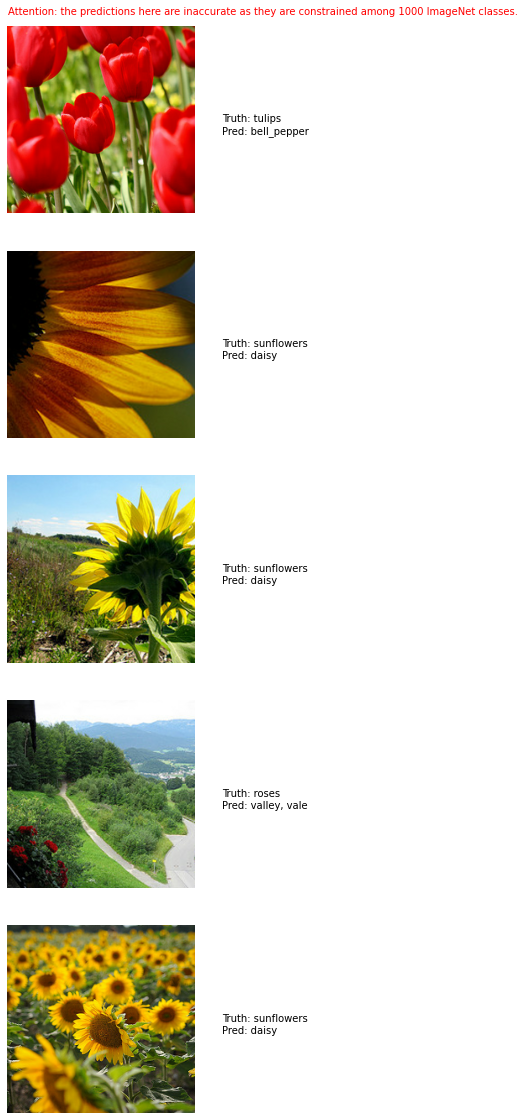

In [27]:
fig, axes = plt.subplots(5, 1, figsize=(20, 20))
for i in range(5):
  axes[i].imshow(image[i])
  true_text = tf_flowers_labels[labels[i]]
  pred_text = imagenet_int_to_str[pred[i]]
  if i == 0:
    axes[i].text(0, 0, 'Attention: the predictions here are inaccurate as they are constrained among 1000 ImageNet classes.\n', c='r')
  axes[i].axis('off')
  axes[i].text(256, 128, 'Truth: ' + true_text + '\n' + 'Pred: ' + pred_text)

#we set a module named mobilenet and batchsize as 32

In [28]:
module_selection = ("mobilenet_v2_100_224", 224) #@param ["(\"mobilenet_v2_100_224\", 224)", "(\"inception_v3\", 299)"] {type:"raw", allow-input: true}
handle_base, pixels = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/imagenet/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

BATCH_SIZE = 32 #@param {type:"integer"}

Using https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4 with input size (224, 224)


#getting the flower images from google storage

In [29]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228818944/228813984 [==============================] - 3s 0us/step


#assigning the dataloaders for our dataset, and assigning images into respective classes.


In [30]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    **datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)

do_data_augmentation = False #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2,
      **datagen_kwargs)
else:
  train_datagen = valid_datagen
train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

Found 731 images belonging to 5 classes.
Found 2939 images belonging to 5 classes.


#fine tuning option to use


In [31]:
do_fine_tuning = False #@param {type:"boolean"}

#setting up our model architecture 

In [32]:
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    # Explicitly define the input shape so the model can be properly
    # loaded by the TFLiteConverter
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes,
                          kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


#compiling our model

In [33]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(lr=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

#training our model

In [34]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
hist = model.fit(
    train_generator,
    epochs=5, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps).history

Epoch 1/5
91/91 [==============================] - ETA: 0s - batch: 45.0000 - size: 31.9451 - loss: 0.9523 - accuracy: 0.7492WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


91/91 [==============================] - 15s 170ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.9523 - accuracy: 0.7492 - val_loss: 0.7340 - val_accuracy: 0.8523
Epoch 2/5
91/91 [==============================] - 16s 178ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.7007 - accuracy: 0.8772 - val_loss: 0.6962 - val_accuracy: 0.8693
Epoch 3/5
91/91 [==============================] - 16s 178ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6564 - accuracy: 0.8985 - val_loss: 0.6814 - val_accuracy: 0.8608
Epoch 4/5
91/91 [==============================] - 16s 177ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6318 - accuracy: 0.9157 - val_loss: 0.6774 - val_accuracy: 0.8821
Epoch 5/5
91/91 [==============================] - 16s 176ms/step - batch: 45.0000 - size: 31.9451 - loss: 0.6068 - accuracy: 0.9226 - val_loss: 0.6813 - val_accuracy: 0.8736


#plotting the results of training 

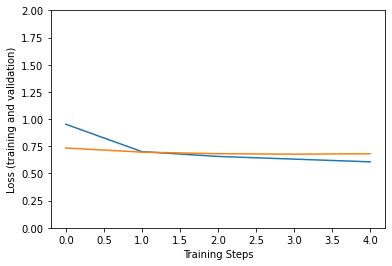

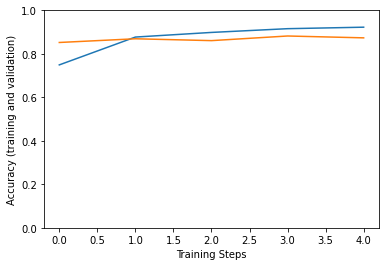

In [35]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])